# Example of using `rate_equation` package

This notebook reproduces relevant figures from [Atoneche (2017)](https://doi.org/10.1088/1361-6404/aa6e6f).

Note that small discrepencies exist, partially because the original paper approximately converts radiation field intensity to absorption rate, whereas `rate_equation` does it exactly. There are also other tiny numeric issues which should not really affect the physics.

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.linalg import null_space
import matplotlib.pyplot as plt


from rate_equation.transition_profile import Transition, TransitionProfile, state, transition, group
from rate_equation.radiation_field import RadiationField, RadiationFieldProfile, frequency
from rate_equation.rate_equation import RateEquation
from rate_equation.detuning import ZeemanDetuning, DopplerDetuning

## Case 1. (Figure 5) Cycling transition from $F_g=2$ to $F_e=3$

Text(0.5, 0, 't / us')

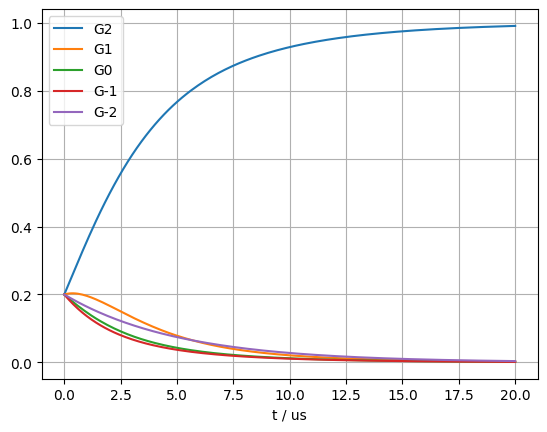

In [2]:
# 87Rb D2-line, Fg=2 -> Fe=3

freq_g2_to_e3 = 384.2304844685e12 + 193.7408e6 - 2.56300597908911e9

trans = TransitionProfile(
        ground_states=[state(s) for s in ["G2", "G1", "G0", "G-1", "G-2"]],
        excited_states=[state(s) for s in ["E3", "E2", "E1", "E0", "E-1", "E-2", "E-3"]],
        transitions=[
            # Metcalf, Appendix D
            transition("G-2", "E-3", 60),
            transition("G-2", "E-2", 20),
            transition("G-2", "E-1", 4),
            transition("G-1", "E-2", 40),
            transition("G-1", "E-1", 32),
            transition("G-1", "E0",  12),
            transition("G0", "E-1",  24),
            transition("G0", "E0",   36),
            transition("G0", "E1",   24),
            transition("G1", "E0",   12),
            transition("G1", "E1",   32),
            transition("G1", "E2",   40),
            transition("G2", "E1",   4),
            transition("G2", "E2",   20),
            transition("G2", "E3",   60),
            ],
        frequencies={
            group("G->E"): freq_g2_to_e3
            },
        gamma=6.0666e6
        )

fields = RadiationFieldProfile([ RadiationField(
    frequency=freq_g2_to_e3,
    delta_m=+1,
    normalized_intensity=0.2
    ) ])

detunings=[]

rate_eqn = RateEquation(trans, fields, detunings)

mat = rate_eqn.build_matrix()

def rate_evolv(t, y):
    return (mat @ y.reshape((-1, 1))).reshape(1, -1)

sol = solve_ivp(rate_evolv, [0, 20e-6], np.ones(5)/5, t_eval=np.linspace(0, 20e-6, 200))

gs = ["G2", "G1", "G0", "G-1", "G-2"]

for i, y_i in enumerate(sol.y):
    plt.plot(1e6*sol.t, y_i, label=gs[i])
    
plt.legend()
plt.grid()
plt.xlabel("t / us")

## Case 4. (Figure 10) Cycling transition from $F_g=2$ to $F_e=3$, Impure polarization

Text(0.5, 0, 't / us')

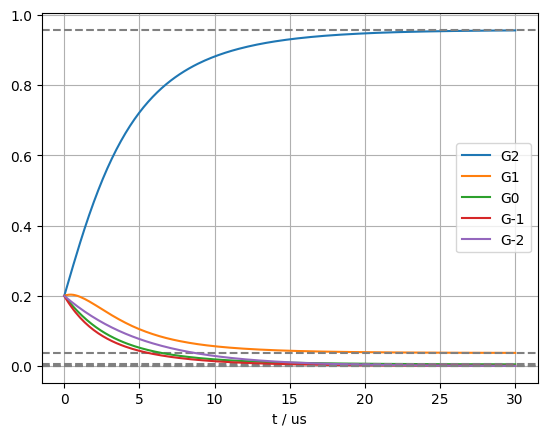

In [3]:
fields = RadiationFieldProfile([ 
    RadiationField(
    frequency=freq_g2_to_e3,
    delta_m=+1,
    normalized_intensity=0.2 * 0.95
    ),
    RadiationField(
    frequency=freq_g2_to_e3,
    delta_m=0,
    normalized_intensity=0.2 * 0.025
    ),
    RadiationField(
    frequency=freq_g2_to_e3,
    delta_m=-1,
    normalized_intensity=0.2 * 0.025
    ),
])

detunings=[]

rate_eqn = RateEquation(trans, fields, detunings)

mat = rate_eqn.build_matrix()

def rate_evolv(t, y):
    return (mat @ y.reshape((-1, 1))).reshape(1, -1)

sol = solve_ivp(rate_evolv, [0, 30e-6], np.ones(5)/5, t_eval=np.linspace(0, 30e-6, 200))

gs = ["G2", "G1", "G0", "G-1", "G-2"]

equlb = null_space(mat)
equlb = equlb / np.sum(equlb)

for i, y_i in enumerate(sol.y):
    plt.plot(1e6*sol.t, y_i, label=gs[i])
    plt.axhline(equlb[i], color="grey", ls="--")
    
plt.legend()
plt.grid()
plt.xlabel("t / us")

## Case 5. (Figure 11) Cycling transition from $F_g=2$ to $F_e=3$, Zeeman shift

Text(0.5, 0, 't / us')

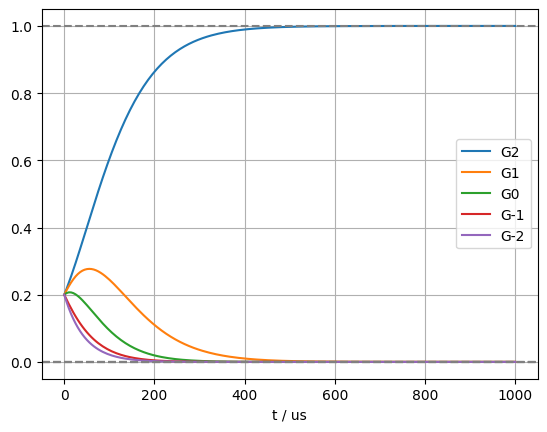

In [4]:
det = ZeemanDetuning(
        g_factors={"G": 1/2, "E": 2/3},
        b_field=-0.002  # T
        )

fields = RadiationFieldProfile([ RadiationField(
    frequency=freq_g2_to_e3,
    delta_m=+1,
    normalized_intensity=0.2
    ) ])

rate_eqn = RateEquation(trans, fields, [det])

mat = rate_eqn.build_matrix()

def rate_evolv(t, y):
    return (mat @ y.reshape((-1, 1))).reshape(1, -1)

sol = solve_ivp(rate_evolv, [0, 1000e-6], np.ones(5)/5, t_eval=np.linspace(0, 1000e-6, 200))

gs = ["G2", "G1", "G0", "G-1", "G-2"]

equlb = null_space(mat)
equlb = equlb / np.sum(equlb)

for i, y_i in enumerate(sol.y):
    plt.plot(1e6*sol.t, y_i, label=gs[i])
    plt.axhline(equlb[i], color="grey", ls="--")
    
plt.legend()
plt.grid()
plt.xlabel("t / us")

## Case 5. (Figure 12) Cycling transition from $F_g=2$ to $F_e=3$, Zeeman shift

Text(0.5, 0, 'Detuning / $\\Gamma$')

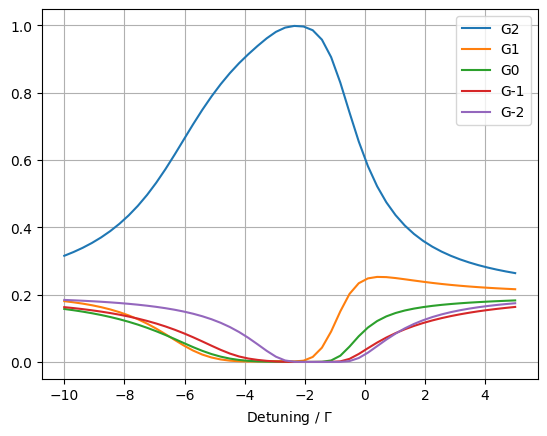

In [5]:
gamma=6.0666e6
rad_dets = np.linspace(-10, 5, 50) * gamma
sol_100_us = []

for rad_det in rad_dets:
    fields = RadiationFieldProfile([ RadiationField(
        frequency=freq_g2_to_e3 + rad_det,
        delta_m=+1,
        normalized_intensity=0.2
        ) ])

    rate_eqn = RateEquation(trans, fields, [det])

    mat = rate_eqn.build_matrix()

    def rate_evolv(t, y):
        return (mat @ y.reshape((-1, 1))).reshape(1, -1)

    sol = solve_ivp(rate_evolv, [0, 100e-6], np.ones(5)/5, t_eval=np.linspace(0, 100e-6, 50))
    
    sol_100_us.append(sol.y[:,-1].flatten())

popu_100_us = np.asarray(sol_100_us).T

gs = ["G2", "G1", "G0", "G-1", "G-2"]

for st, popu in zip(gs, popu_100_us):
    plt.plot(rad_dets / gamma, popu, label=st)

plt.grid()
plt.legend()
plt.xlabel(r"Detuning / $\Gamma$")

## Case 2. (Figure 7) Prepare state $F_g=1, M_g=0$

Text(0.5, 0, 't / us')

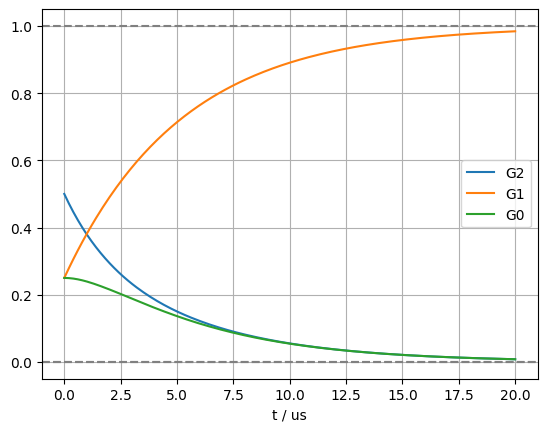

In [6]:
# 87Rb D2-line, Fg=1 -> Fe=0

freq_g1_to_e0 = 384.2304844685e12 - 302.0738e6 + 4.27167663181519e9

trans = TransitionProfile(
        ground_states=[state(s) for s in ["G1", "G0", "G-1"]],
        excited_states=[state("E0")],
        transitions=[
            transition("G1", "E0", 20),
            transition("G0", "E0", 20),
            transition("G-1", "E0", 20),
            ],
        frequencies={
            group("G->E"): freq_g1_to_e0,
            },
        gamma=6.0666e6
        )

fields = RadiationFieldProfile([ 
    RadiationField(
    frequency=freq_g1_to_e0,
    delta_m=+1,
    normalized_intensity=0.1
    ),
    RadiationField(
    frequency=freq_g1_to_e0,
    delta_m=-1,
    normalized_intensity=0.1
    ) 
])

detunings = []

rate_eqn = RateEquation(trans, fields, detunings)

mat = rate_eqn.build_matrix()

def rate_evolv(t, y):
    return (mat @ y.reshape((-1, 1))).reshape(1, -1)

sol = solve_ivp(rate_evolv, [0, 20e-6], np.array([0.5, 0.25, 0.25]), t_eval=np.linspace(0, 20e-6, 200))

equlb = null_space(mat)
equlb = equlb / np.sum(equlb)

for i, y_i in enumerate(sol.y):
    plt.plot(1e6*sol.t, y_i, label=gs[i])
    plt.axhline(equlb[i], color="grey", ls="--")
    
plt.legend()
plt.grid()
plt.xlabel("t / us")

## Case 3. (Figure 9) Prepare state $F_g=2, M_g=0$

Text(0.5, 0, 't / us')

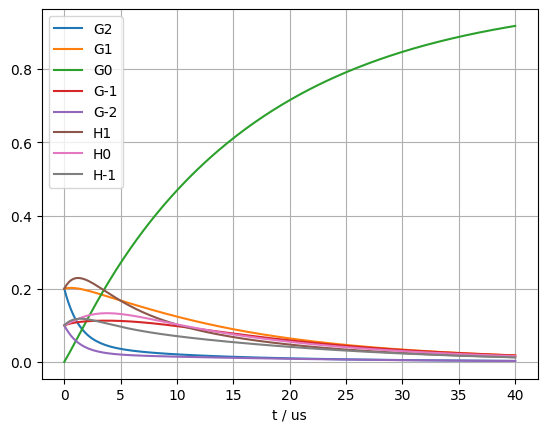

In [7]:
# 87Rb D2-line, Fg=2 -> Fe=2
g2_to_e2 = [
            transition("G-2", "E-2", 20),
            transition("G-2", "E-1", 10),
            transition("G-1", "E-2", 10),
            transition("G-1", "E-1", 5),
            transition("G-1", "E0",  15),
            transition("G0", "E-1",  15),
            transition("G0", "E0",   0),
            transition("G0", "E1",   15),
            transition("G1", "E0",   15),
            transition("G1", "E1",   5),
            transition("G1", "E2",   10),
            transition("G2", "E1",   10),
            transition("G2", "E2",   20),
            ]

g1_to_e2 = [
            transition("H-1", "E-2", 30),
            transition("H-1", "E-1", 15),
            transition("H-1", "E0",  5),
            transition("H0", "E-1",  15),
            transition("H0", "E0",   20),
            transition("H0", "E1",   15),
            transition("H1", "E0",    5),
            transition("H1", "E1",   15),
            transition("H1", "E2",   30),
            ]


freq_g1_to_e2 = 384.2304844685e12 - 72.9113e6 + 4.27167663181519e9
freq_g2_to_e2 = 384.2304844685e12 - 72.9113e6 - 2.56300597908911e9


trans = TransitionProfile(
    ground_states=[state(s) for s in ["G2", "G1", "G0", "G-1", "G-2", "H1", "H0", "H-1" ]],
    excited_states=[state(s) for s in ["E2", "E1", "E0", "E-1", "E-2"]],
    transitions=(g2_to_e2 + g1_to_e2),
    frequencies={
        # Fg=1 -> Fe=2
        group("H->E"): freq_g1_to_e2,
        # Fg=2 -> Fe=2
        group("G->E"): freq_g2_to_e2
    },
    gamma=6.0666e6
)

fields = RadiationFieldProfile([ 
    RadiationField( # Fg=2 -> Fe=2
    frequency=freq_g2_to_e2,
    delta_m=0,
    normalized_intensity=0.2
    ),
    RadiationField( # Fg=1 -> Fe=2
    frequency=freq_g1_to_e2,
    delta_m=0,
    normalized_intensity=0.1
    ) 
])
    
detunings = []

rate_eqn = RateEquation(trans, fields, detunings)

mat = rate_eqn.build_matrix()

def rate_evolv(t, y):
    return (mat @ y.reshape((-1, 1))).reshape(1, -1)

num_gs = len(trans.ground_states)

# ["G2", "G1", "G0", "G-1", "G-2", "H1", "H0", "H-1" ]
init_gs = [0.2, 0.2, 0, 0.1, 0.1, 0.2, 0.1, 0.1]

sol = solve_ivp(rate_evolv, [0, 40e-6], init_gs, t_eval=np.linspace(0, 40e-6, 200))

gs = ["G2", "G1", "G0", "G-1", "G-2", "H1", "H0", "H-1" ]

for i, y_i in enumerate(sol.y):
    plt.plot(1e6*sol.t, y_i, label=gs[i])

plt.legend()
plt.grid()
plt.xlabel("t / us")